Create the proteome NSAF of all proteins

Copied source code from Tine Claeys

In [1]:
import pandas as pd
import mysql.connector
import numpy as np

In [2]:
conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

connection succesfull


In [12]:
assaysql = "SELECT assay_id, peptide_id, quantification FROM peptide_to_assay"
assayData = pd.read_sql_query(assaysql, conn)
assayData.head()

,assay_id,peptide_id,quantification
0,29379,104508336,1.0
1,29380,104508336,1.0
2,29381,104508336,1.0
3,29382,104508336,2.0
4,29383,104508336,1.0


Get all peptide to protein relations

In [11]:
pepsql = "SELECT peptide_to_protein.peptide_id, peptide_to_protein.uniprot_id FROM peptide_to_protein"
pepData = pd.read_sql_query(pepsql, conn)
pepData.head()

,peptide_id,uniprot_id
0,107613935,A0A024RBG1
1,108668962,A0A024RBG1
2,108763137,A0A075B6H7
3,105416976,A0A075B6H8
4,105352686,A0A075B6I1


Get sequence length for all proteins in the database

In [13]:
seqsql = "SELECT uniprot_id, length FROM protein WHERE length IS NOT NULL"
seqData = pd.read_sql_query(seqsql, conn)
seqData["length"] = pd.to_numeric(seqData['length'], errors = "coerce")
seqData.head()

,uniprot_id,length
0,A0A024RBG1,181.0
1,A0A075B6H7,116.0
2,A0A075B6H8,117.0
3,A0A075B6I1,120.0
4,A0A075B6R9,120.0


Select proteotypic peptides (peptide with 1 peptide to protein relation)

In [14]:
proteotypicData = pepData.groupby("peptide_id").filter(lambda x: len(x) == 1)
proteotypicData

,peptide_id,uniprot_id
0,107613935,A0A024RBG1
1,108668962,A0A024RBG1
2,108763137,A0A075B6H7
3,105416976,A0A075B6H8
4,105352686,A0A075B6I1
...,...,...
123402,109417357,TRYP_PIG
123403,110185316,TRYP_PIG
123404,106954178,W5XKT8
123405,107221607,W5XKT8


In [17]:
proteins = proteotypicData.groupby("uniprot_id").filter(lambda x: len(x) > 2)
proteins.shape

(118126, 2)

In [26]:
non_human_proteins = non_human = """ADH1_YEAST,,,
ALBU_BOVIN,,,
ALDOA_RABIT,,,
BGAL_ECOLI,,,
CAH2_BOVIN,,,
CAS1_BOVIN,,,
CAS2_BOVIN,,,
CASB_BOVIN,,,
CASK_BOVIN,,,
CYC_HORSE,,,
DHE3_BOVIN,,,
GAG_SCVLA,,,
GFP_AEQVI,,,
K1C15_SHEEP,,,
K1M1_SHEEP,,,
K1M2_SHEEP,,,
K2M1_SHEEP,,,
K2M2_SHEEP,,,
K2M3_SHEEP,,,
KRA3_SHEEP,,,
KRA61_SHEEP,,,
LALBA_BOVIN,,,
LYSC_CHICK,,,
LYSC_LYSEN,,,
MYG_HORSE,,,
REF_HEVBR,,,
SRPP_HEVBR,,,
TRY1_BOVIN,,,
TRYP_PIG""".split(",,,\n")
proteins = proteins[~proteins["uniprot_id"].isin(non_human_proteins)]

Merge assays containing spectral counts and proteins

In [28]:
protData = pd.merge(assayData, proteins, on = "peptide_id").sort_values(["assay_id", "uniprot_id"])
del protData['peptide_id']
protData.head(10)

,assay_id,quantification,uniprot_id
143315,29379,1.0,A0A1B0GUS4
1051907,29379,1.0,A0A1B0GUS4
85974,29379,1.0,A0AVT1
849012,29379,1.0,A0AVT1
195165,29379,1.0,A6NDG6
758822,29379,1.0,A6NDG6
772288,29379,1.0,A6NDG6
40777,29379,2.0,A6NHL2
464771,29379,1.0,A6NHQ2
740314,29379,1.0,A6NHR9


Split data per assay

In [44]:
assays = protData['assay_id'].unique()
DataFramaDict = {elem: pd.DataFrame for elem in assays}
for key in DataFramaDict.keys():
    DataFramaDict[key] = protData[:][protData["assay_id"] ==  key]

DataFramaDict2 = DataFramaDict.copy()

Calculate NSAF score for each protein per assay

In [45]:
for count, key in enumerate(DataFramaDict2.keys()):
    sumSaf = 0
    assay = DataFramaDict2[key]
    assay.pop("assay_id")

    #calculate sum of spectral counts for each protein
    grouped = DataFramaDict2[key].groupby("uniprot_id").sum().reset_index()
    seqAddedDF = pd.merge(grouped, seqData, on = "uniprot_id")
    seqAddedDF.insert(loc = 2, column = 'SAF', value = 0)
    seqAddedDF.insert(loc = 3, column = 'NSAF', value = 0)
    
    #Calculate SAF score for each protein by dividing sum of spectral counts by protein length
    for index, row in seqAddedDF.iterrows():
        saf = row['quantification']/row['length']
        seqAddedDF.loc[index, 'SAF'] = saf
        # calculate sum of SAF scores in assay
        sumSaf += saf

    # Calculate NSAF score by normalizing each SAF score
    seqAddedDF["NSAF"] = seqAddedDF["SAF"] / sumSaf
    
    del seqAddedDF['length']
    del seqAddedDF['quantification']
    del seqAddedDF['SAF']
    seqAddedDF.insert(loc = 0, column = 'assay_id', value = key)
    DataFramaDict2[key] = seqAddedDF


In [46]:
proteinData = pd.DataFrame()

for key in DataFramaDict2.keys():
    proteinData = proteinData.append(DataFramaDict2[key])

In [47]:
proteinData.head()

,assay_id,uniprot_id,NSAF
0,29379,A0A1B0GUS4,0.001460
1,29379,A0AVT1,0.000214
2,29379,A6NDG6,0.001051
3,29379,A6NHL2,0.000504
4,29379,A6NHQ2,0.000337


In [3]:
#write NSAF proteome to file
proteinData.to_csv(path_or_buf = 'proteome_nsaf_1.csv', index = False)
df = pd.read_csv('proteome_nsaf_1.csv')
df.head()

NameError: name 'proteinData' is not defined

## Create the NSAF atlas, a minmax version of the NSAF atlas, a heatmap and the proteinCount per tissue file

In [57]:
df = pd.read_csv("proteome_nsaf_1.csv")

assay_project_query = "SELECT assay_id, project_id FROM assay"
assay_project_data = pd.read_sql_query(assay_project_query, conn)

assay_cell_query = "SELECT assay_id, cell_id FROM cell_to_assay"
assay_cell_data = pd.read_sql_query(assay_cell_query, conn)

cell_query = "SELECT cell_id, cell_line, disease FROM cell"
cell_data = pd.read_sql_query(cell_query, conn)

full_df = pd.merge(df, assay_project_data, on = "assay_id")
print(full_df.loc[full_df.project_id == 1791])
full_df = pd.merge(full_df, assay_cell_data, on = "assay_id")
full_df = pd.merge(full_df, cell_data, on = "cell_id")

cell_lines = full_df.cell_line
projects = full_df.project_id

full_df

        assay_id uniprot_id      NSAF  project_id
525603     30321     A0AVT1  0.000116        1791
525604     30321     A6NHL2  0.000273        1791
525605     30321     O00148  0.000285        1791
525606     30321     O00154  0.000641        1791
525607     30321     O00231  0.002308        1791
...          ...        ...       ...         ...
530619     30325     Q9Y6A4  0.000545        1791
530620     30325     Q9Y6C9  0.000347        1791
530621     30325     Q9Y6N5  0.000234        1791
530622     30325     Q9Y6X9  0.000102        1791
530623     30325     Q9Y6Y8  0.000105        1791

[5021 rows x 4 columns]


,assay_id,uniprot_id,NSAF,project_id,cell_id,cell_line,disease
0,29379,A0A1B0GUS4,0.001460,1777,452,HL60,Acute myeloid leukemia
1,29379,A0AVT1,0.000214,1777,452,HL60,Acute myeloid leukemia
2,29379,A6NDG6,0.001051,1777,452,HL60,Acute myeloid leukemia
3,29379,A6NHL2,0.000504,1777,452,HL60,Acute myeloid leukemia
4,29379,A6NHQ2,0.000337,1777,452,HL60,Acute myeloid leukemia
...,...,...,...,...,...,...,...
1128051,30905,Q9Y5P6,0.000515,1807,543,hNPC,/
1128052,30905,Q9Y5S9,0.001065,1807,543,hNPC,/
1128053,30905,Q9Y617,0.002505,1807,543,hNPC,/
1128054,30905,Q9Y678,0.000424,1807,543,hNPC,/


REMARK: I have 43 cell lines, but in this table only 35 show up... where is my HeLa???

In [14]:
NSAF_data_table = pd.pivot_table(full_df, values = 'NSAF', index = 'uniprot_id', columns = 'cell_line').fillna(0)
NSAF_data_table

cell_line,A2780,A2780-DR,BeWo,CAF,HDF,HEK293,HEK293F,HL60,HT29,HTR8/SVneo,...,THP1 monocyte,ZR751,ZR751 CAF coculture,cerebral organoid,hNPC,hNPC differentiated,human articular chondrocyte,iPSC,lung MSC/bone marrow MSC,neuron
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2F0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002021,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000459,0.000536,0.000000,0.000000,0.000000,0.000000
A0A1B0GUS4,0.000491,0.000532,0.000000,0.000000,0.000000,0.000622,0.000000,0.000805,0.000226,0.000000,...,0.000153,0.000000,0.000000,0.000000,0.000538,0.000000,0.000379,0.000000,0.001736,0.000839
A0A1W2PRP0,0.000324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000210,0.000000,0.000000,0.000103,0.000000,0.000000,0.000000
A0AVK6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000066,0.000000,0.000000,0.000000,0.000000,...,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0AVT1,0.000436,0.000482,0.000111,0.000435,0.001319,0.000283,0.000652,0.000597,0.000524,0.000214,...,0.000521,0.000300,0.000292,0.000300,0.000310,0.000389,0.000188,0.000000,0.001194,0.000121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000587,0.000000,0.000000,0.000000,0.000000,...,0.000039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000230,0.000000
Q9Y6X8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000159,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000058,0.000051,0.000044,0.000031,0.000000,0.000000,0.000000
Q9Y6X9,0.000000,0.000000,0.000000,0.000071,0.000000,0.000167,0.000390,0.001923,0.000122,0.000000,...,0.000029,0.000109,0.000117,0.000045,0.000130,0.000122,0.000000,0.000000,0.000000,0.000000


In [16]:
#minmax scaling so values lie between 0 and 1
minmax_atlas = (NSAF_data_table - NSAF_data_table.min()) / (NSAF_data_table.max() - NSAF_data_table.min())
minmax_atlas

cell_line,A2780,A2780-DR,BeWo,CAF,HDF,HEK293,HEK293F,HL60,HT29,HTR8/SVneo,...,THP1 monocyte,ZR751,ZR751 CAF coculture,cerebral organoid,hNPC,hNPC differentiated,human articular chondrocyte,iPSC,lung MSC/bone marrow MSC,neuron
uniprot_id,,,,,,,,,,,,,,,,,,,,,
A0A0B4J2F0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.039984,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.009824,0.015225,0.000000,0.00000,0.000000,0.000000
A0A1B0GUS4,0.024009,0.016975,0.00000,0.000000,0.000000,0.019946,0.000000,0.015935,0.002302,0.000000,...,0.008963,0.000000,0.000000,0.000000,0.011523,0.000000,0.007810,0.00000,0.046398,0.014951
A0A1W2PRP0,0.015869,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.016764,0.000000,0.000000,0.002131,0.00000,0.000000,0.000000
A0AVK6,0.000000,0.000000,0.00000,0.000000,0.000000,0.002122,0.000000,0.000000,0.000000,0.000000,...,0.001216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
A0AVT1,0.021339,0.015360,0.00584,0.021291,0.008981,0.009081,0.007741,0.011804,0.005337,0.008228,...,0.030566,0.012021,0.013910,0.024006,0.006636,0.011045,0.003878,0.00000,0.031907,0.002164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6X5,0.000000,0.000000,0.00000,0.000000,0.000000,0.018823,0.000000,0.000000,0.000000,0.000000,...,0.002271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.006155,0.000000
Q9Y6X8,0.000000,0.000000,0.00000,0.000000,0.000000,0.005087,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.004599,0.001101,0.001261,0.000632,0.00000,0.000000,0.000000
Q9Y6X9,0.000000,0.000000,0.00000,0.003451,0.000000,0.005337,0.004634,0.038038,0.001240,0.000000,...,0.001678,0.004371,0.005559,0.003606,0.002787,0.003478,0.000000,0.00000,0.000000,0.000000


In [17]:
cols = minmax_atlas.columns
minmax_atlas[cols] = minmax_atlas[cols].apply(pd.to_numeric, errors='coerce')
minmax_atlas.idxmax()

cell_line
A2780                          P62805
A2780-DR                       P62805
BeWo                           P31949
CAF                            P09382
HDF                            P62805
HEK293                         P62805
HEK293F                        P62306
HL60                           P62805
HT29                           P62805
HTR8/SVneo                     P63313
JURKAT                         P62857
KO52                           O95059
LAN5                           P62805
LN308                          P62805
MCF7                           Q9H1E3
MCF7 CAF coculture             P62805
MDA-MB-231                     P62805
MDA-MB-231-CSC                 P62805
MDA-MB-231-R                   P62805
SH-SY5Y                        P62805
SK-N-BE2                       Q9H1E3
SKBR3                          P62805
THP1 M1 macrophage             P31949
THP1 M2 macrophage             P31949
THP1 macrophage                P09382
THP1 monocyte                  P62805
ZR

Remark: P62805 is most prevalent in almost all cell lines. P62805 is the H4 histon protein

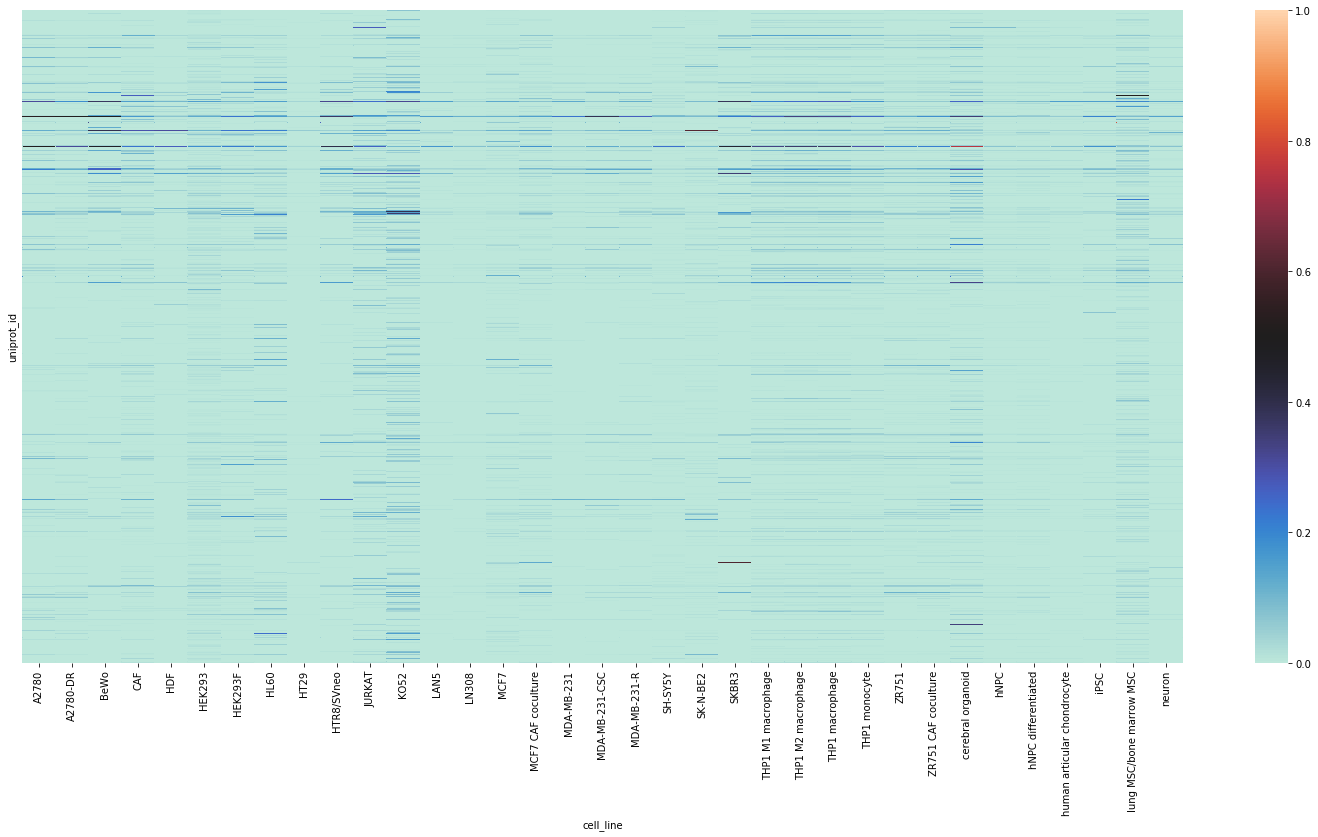

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
fig, ax = plt.subplots(figsize=(26,12))
datamap = sns.heatmap(minmax_atlas, ax=ax, yticklabels = False,cmap='icefire')
#datamap.figure.savefig('heatmap_expressionpurple0806.png')
datamap

In [34]:
# split dataset per cell
tissues = full_df['cell_line'].unique()
DataFrameDict3 = {elem : pd.DataFrame for elem in tissues}
for key in DataFrameDict3.keys():
    DataFrameDict3[key] = full_df[:][full_df['cell_line'] == key]

In [35]:
# count number of proteins for each cell
proteinCount = {}

for key in DataFrameDict3.keys():
    cell_line = DataFrameDict3[key].pop('cell_line')
    grouped = DataFrameDict3[key].groupby('uniprot_id').mean().reset_index()
    count = len(grouped.index)
    proteinCount[key] = str(count)

In [36]:

for key, val in proteinCount.items():
    print(key + ":" + val)

HL60:2148
LAN5:2097
MCF7:4375
HEK293F:2158
CAF:2170
MCF7 CAF coculture:2471
ZR751:2759
ZR751 CAF coculture:2850
SKBR3:1048
KO52:2334
BeWo:979
HTR8/SVneo:1012
HDF:1024
SH-SY5Y:5599
MDA-MB-231-R:1485
MDA-MB-231:1092
MDA-MB-231-CSC:1056
SK-N-BE2:5509
A2780:1361
A2780-DR:1755
HEK293:5692
human articular chondrocyte:3893
hNPC differentiated:4749
hNPC:5418
JURKAT:1801
lung MSC/bone marrow MSC:3928
cerebral organoid:2786
LN308:3852
HT29:2548
THP1 macrophage:3275
THP1 M1 macrophage:3553
THP1 M2 macrophage:3585
THP1 monocyte:3359
iPSC:1255
neuron:1315


## Making a t-SNE plot

In [72]:
query = "SELECT assay_id, cell_id FROM cell_to_assay"
query2 = "SELECT cell_id, cell_line, disease FROM cell"
query3 = "SELECT assay_id, project_id FROM assay"
cell_assay = pd.read_sql_query(query, conn)
cell = pd.read_sql_query(query2, conn)
project = pd.read_sql_query(query3, conn)
grouped = pd.merge(cell_assay, cell, on = "cell_id")
grouped = pd.merge(grouped, project, on = "assay_id")
grouped

,assay_id,cell_id,cell_line,disease,project_id
0,29379,452,HL60,Acute myeloid leukemia,1777
1,29380,452,HL60,Acute myeloid leukemia,1777
2,29381,452,HL60,Acute myeloid leukemia,1777
3,29382,452,HL60,Acute myeloid leukemia,1777
4,29383,452,HL60,Acute myeloid leukemia,1777
...,...,...,...,...,...
1576,30955,544,NALM6,B-cell acute lymphoblastic leukemia,1813
1577,30956,544,NALM6,B-cell acute lymphoblastic leukemia,1813
1578,30957,544,NALM6,B-cell acute lymphoblastic leukemia,1813
1579,30958,544,NALM6,B-cell acute lymphoblastic leukemia,1813


In [73]:
assay_atlas = pd.pivot_table(full_df, values = 'NSAF', index = 'assay_id', columns = 'uniprot_id').fillna(0).reset_index()
assay_atlas

uniprot_id,assay_id,A0A0B4J2F0,A0A1B0GUS4,A0A1W2PRP0,A0AVK6,A0AVT1,A0JNW5,A0MZ66,A0PJW6,A0PJZ3,...,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X0,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,29379,0.0,0.001460,0.0,0.0,0.000214,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,29380,0.0,0.000715,0.0,0.0,0.000523,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000221,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,29381,0.0,0.000719,0.0,0.0,0.000421,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29382,0.0,0.000709,0.0,0.0,0.000415,0.000075,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,29383,0.0,0.000000,0.0,0.0,0.000411,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,30901,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
982,30902,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
983,30903,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984,30904,0.0,0.000940,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
atlas = pd.merge(assay_atlas, grouped, on = 'assay_id')
atlas = atlas.drop(['assay_id', 'cell_id'], axis=1)
atlas.head()

,A0A0B4J2F0,A0A1B0GUS4,A0A1W2PRP0,A0AVK6,A0AVT1,A0JNW5,A0MZ66,A0PJW6,A0PJZ3,A1A4S6,...,Q9Y6X0,Q9Y6X3,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8,cell_line,disease,project_id
0,0.0,0.001460,0.0,0.0,0.000214,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HL60,Acute myeloid leukemia,1777
1,0.0,0.000715,0.0,0.0,0.000523,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HL60,Acute myeloid leukemia,1777
2,0.0,0.000719,0.0,0.0,0.000421,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HL60,Acute myeloid leukemia,1777
3,0.0,0.000709,0.0,0.0,0.000415,0.000075,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HL60,Acute myeloid leukemia,1777
4,0.0,0.000000,0.0,0.0,0.000411,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HL60,Acute myeloid leukemia,1777


In [76]:
atlas.to_csv('tsne_atlas.csv', index=False)

In [ ]:
atlas = pd.read_csv('tsne_atlas.csv')

In [77]:
cells = atlas.pop('cell_line')
disease = atlas.pop("disease")
projects = atlas.pop('project_id')
values = atlas

In [78]:
from sklearn.manifold import TSNE
import seaborn as sns

In [97]:
tsne = TSNE(n_components = 2, perplexity = 20)
tsne_results = tsne.fit_transform(values)
principalDf = pd.DataFrame(data = tsne_results, columns = ['TSNE_1', 'TSNE_2'])

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [98]:
finalDF = pd.concat([principalDf, cells, projects, disease], axis = 1)

In [99]:
finalDF.head()

,TSNE_1,TSNE_2,cell_line,project_id,disease
0,-10.350244,-2.191505,HL60,1777,Acute myeloid leukemia
1,-9.860861,-2.361047,HL60,1777,Acute myeloid leukemia
2,-10.553133,-1.712270,HL60,1777,Acute myeloid leukemia
3,-10.050618,-1.898515,HL60,1777,Acute myeloid leukemia
4,-10.896137,-2.397307,HL60,1777,Acute myeloid leukemia


In [100]:
palettes = ['Paired', 'Set3', 'Dark2', 'Accent', 'Pastel1', 'Pastel2', 'Spectral']
cell_colors = []
for i in palettes:
    x = sns.color_palette(i)
    l = x.as_hex()
    for ll in l:
        cell_colors.append(ll)
print(len(cell_colors))
print(len(np.unique(cells)))

63
35


In [101]:
import random
palettes = ['Paired', 'Set3', 'Dark2', 'Accent', 'Pastel1', 'Pastel2', 'Spectral', 'BrBG', 'PuOr', 'RdGy', 'Blues', 'Oranges', 'Purples', 'Reds', 'YlOrBr']
project_colors = []
for i in palettes:
    x = sns.color_palette(i)
    l = x.as_hex()
    for ll in l:
        project_colors.append(ll)
for r in random.sample(project_colors, 82):
    project_colors.append(r)

print(len(project_colors))
print(len(np.unique(projects)))

193
27


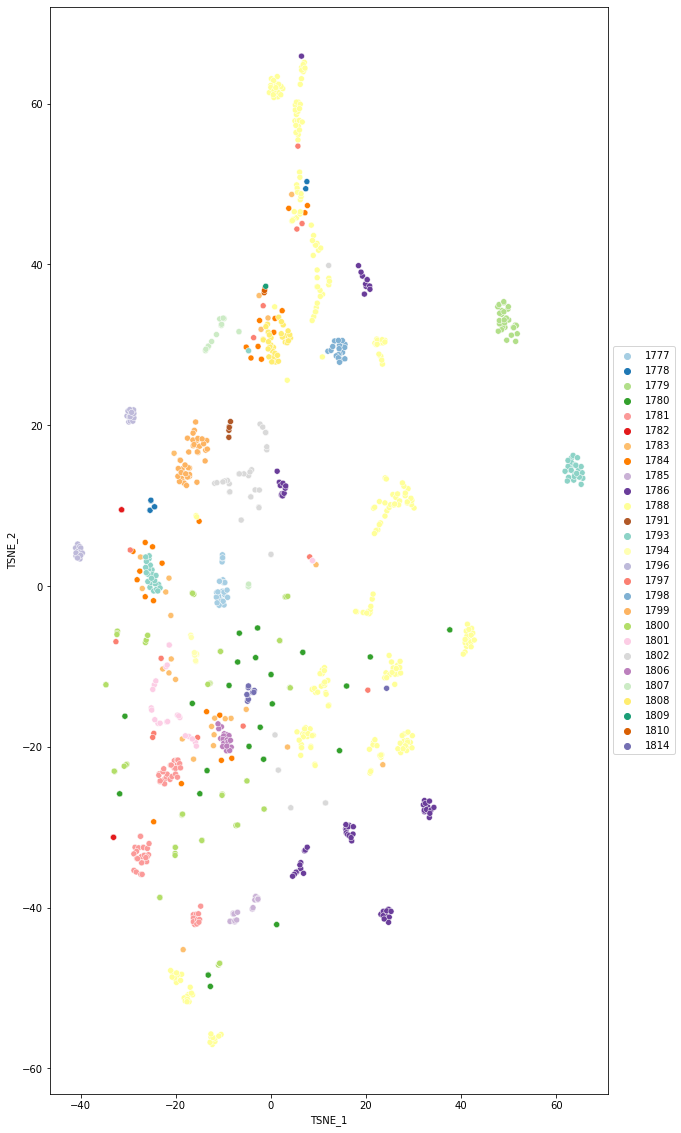

In [103]:
c = len(np.unique(finalDF['project_id']))
pal = sns.color_palette("Spectral", n_colors=c)
fig, ax=plt.subplots(figsize=(10,20))
g = sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='project_id', palette=project_colors[:27])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))

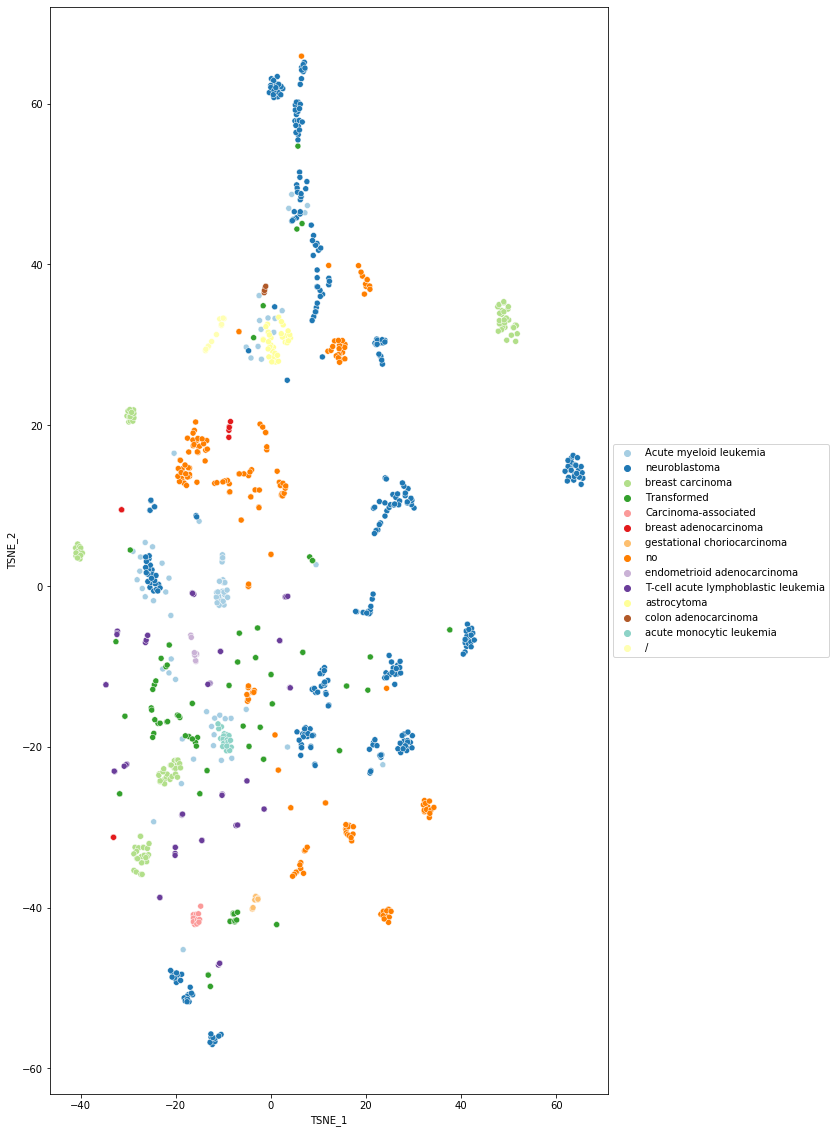

In [104]:
c = len(np.unique(finalDF['disease']))
pal = sns.color_palette("Spectral", n_colors=c)
fig, ax=plt.subplots(figsize=(10,20))
g = sns.scatterplot(data=finalDF, x='TSNE_1', y='TSNE_2', hue='disease', palette=project_colors[:c])
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))